<h3>Load helper functions</h3>

In [3]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code> and <code>all_issues</code> and Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>NOTE These are saved csvs and can be loaded using <code>load_gk_issues_for_analysis()</code> and <code>load_non_gk_issues_for_analysis()</code></p>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [4]:
gk_issues = load_gk_issues_for_analysis()
non_gk_issues = load_non_gk_issues_for_analysis()

<h2>Observation 1) Approximately 40% of IRs are GKIRs</h2>

In [6]:
non_gk_issues__count = (
    non_gk_issues
        .groupby('repo_name')['id']
        .count()
        .to_frame(name='issue_count')
        .reset_index()
)
gk_issues__count = (
    gk_issues
        .groupby('repo_name')['id']
        .count()
        .to_frame(name='issue_count')
        .reset_index()
)

gk_to_non_gk_issue_counts = non_gk_issues__count.merge(
    gk_issues__count,
    on='repo_name',
    how='inner',
    suffixes=['_non_gk', '_gk'],
)
gk_to_non_gk_issue_counts['proportion_gk'] = (
    gk_to_non_gk_issue_counts['issue_count_gk'] / 
    (gk_to_non_gk_issue_counts['issue_count_gk'] + gk_to_non_gk_issue_counts['issue_count_non_gk'])
)
gk_to_non_gk_issue_counts['isue_count_total'] = gk_to_non_gk_issue_counts['issue_count_non_gk'] + gk_to_non_gk_issue_counts['issue_count_gk']

gk_to_non_gk_issue_counts['higher_than_median'] = (
    gk_to_non_gk_issue_counts['isue_count_total'] >= gk_to_non_gk_issue_counts['isue_count_total'].median()
)

for_plot = pd.DataFrame({
    'proportion_gk': gk_to_non_gk_issue_counts['proportion_gk'],
    'higher_than_median': False
})

for_plot = for_plot.append(
    pd.DataFrame({
        'proportion_gk': gk_to_non_gk_issue_counts.loc[
            gk_to_non_gk_issue_counts['higher_than_median'],
            'proportion_gk'
        ],
        'higher_than_median': True 
    })
)
for_plot['placeholder'] = ''

In [7]:
print('--What proportion of issues in a project are GK issues?--')
tfns(
    gk_to_non_gk_issue_counts,
    ['proportion_gk', 'issue_count_gk', 'issue_count_non_gk'],
    should_round=False
)
print('--What proportion of issues in a project are GK issues (With at least the median total number of issues)?--')
tfns(
    gk_to_non_gk_issue_counts[gk_to_non_gk_issue_counts['higher_than_median']],
    ['proportion_gk', 'issue_count_gk', 'issue_count_non_gk'],
    should_round=True
)
print('--What proportion of issues in a project are GK issues (With less than the median total number of issues)?--')
tfns(
    gk_to_non_gk_issue_counts[~gk_to_non_gk_issue_counts['higher_than_median']],
    ['proportion_gk', 'issue_count_gk', 'issue_count_non_gk'],
    should_round=True
)

--What proportion of issues in a project are GK issues?--
                      Count       Mean         STD          Min    25%    Median        75%          Max
------------------  -------  ---------  ----------  -----------  -----  --------  ---------  -----------
proportion_gk          6824   0.515988    0.294666  0.000114548   0.25       0.5   0.777778     0.997792
issue_count_gk         6824  12.848      34.7275    1             2          5    12         1781
issue_count_non_gk     6824  41.8457    250.269     1             1          4    14         9633

--What proportion of issues in a project are GK issues (With at least the median total number of issues)?--
                      Count    Mean      STD    Min    25%    Median     75%       Max
------------------  -------  ------  -------  -----  -----  --------  ------  --------
proportion_gk          3560   0.466    0.342      0   0.13     0.417   0.819     0.998
issue_count_gk         3560  21.584   46.34       1   6      

Saving figure projects_proportion_of_gk_issues


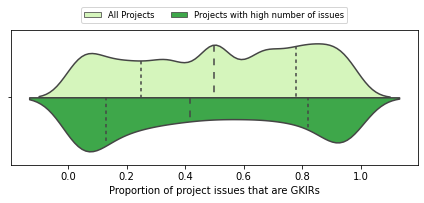

In [17]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='proportion_gk',
    y='placeholder',
    hue='higher_than_median',
    split=True,
    inner='quartile',
    # palette=['1', '0.6'],
    palette=['#d4ffb2', '#2db83d'],
    scale='width',
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of project issues that are GKIRs')
ax.legend(
    title='',
)
L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('All Projects')
L.get_texts()[1].set_text('Projects with high number of issues')

save_fig('projects_proportion_of_gk_issues')
plt.show()

<h2>Observation 2) What proportion of in-range breaking build issue reports are closed (i.e., resolved)?</h2>
<p>
    Overall, in-range breaking build issue reports are closed 79.8% of the time (20.2% are never closed).
    <br>
    When comparing at the intra-project level, the median proportion of in-range breaking build issue reports closed by individual projects is 100% (median for other issues is 0.905). Projects are closing in-range breaking build issue reports at the same rate as other issues in the project (median ratio for gk to non-gk is 1.022).
</p>

In [42]:
proportions = (
    gk_issues['state'].value_counts() / 
    gk_issues['state'].count()
).to_frame(name='proportion')\
    .rename_axis('state')\
    .reset_index()
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
proportions.head()

--All GK in-range breaking issue state proportions (not calculated per project)--


,state,proportion
0,closed,0.822751
1,open,0.177249


In [43]:
proportions = (
    non_gk_issues['state'].value_counts() / 
    non_gk_issues['state'].count()
).to_frame(name='proportion')\
    .rename_axis('state')\
    .reset_index()
print('--All non-GKIRs state proportions (not calculated per project)--')
proportions.head()

--All non-GKIRs state proportions (not calculated per project)--


,state,proportion
0,closed,0.7984
1,open,0.2016


In [44]:
non_gk_issues__state_proportions = (
    (
        non_gk_issues.groupby('repo_name', observed=True)['state'].value_counts() / 
        non_gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)
gk_issues__state_proportions = (
    (
        gk_issues.groupby('repo_name')['state'].value_counts() / 
        gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)

project_issue__state_proportions = non_gk_issues__state_proportions.merge(
    gk_issues__state_proportions,
    how='inner',
    on=['repo_name', 'state'],
    suffixes=['_non_gk', '_gk'],
)
project_issue__state_proportions['ratio'] = project_issue__state_proportions['proportion_gk'] / project_issue__state_proportions['proportion_non_gk']
project_issue__state_proportions__closed = project_issue__state_proportions[project_issue__state_proportions['state'] == 'closed']

print('--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk', 'ratio'], title='Proportion of closed issues')
plt.show()

mannwhitneyu_cliffsdelta(
    project_issue__state_proportions__closed['proportion_gk'],
    project_issue__state_proportions__closed['proportion_non_gk']
)

--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--
Proportion of closed issues      Count    Mean      STD    Min    25%    Median    75%     Max
-----------------------------  -------  ------  -------  -----  -----  --------  -----  ------
proportion_non_gk                 5271  17.377  115.443  0       0.25         1  4.5    4586.5
proportion_gk                     5271   0.927    0.186  0.032   1            1  1         1
ratio                             5271  15.007   98.41   0       0.2          1  3.556  4069

	Mann-Whitney: statistic=13106745.0 pvalue=6.128037226553316e-08
	Cliff'a Delta: delta=-0.05650671563684282 size=negligible
    


<h4>Project ratio between proportion of closed non-gk issues and gk issues</h4>

In [45]:
projects_with_high_gk_counts = (
    gk_to_non_gk_issue_counts[
        gk_to_non_gk_issue_counts['issue_count_gk'] >= gk_to_non_gk_issue_counts['issue_count_gk'].median()
    ]['repo_name'].copy().reset_index(drop=True)
)

project_issue_with_high_gk_counts__state_proportions = (
    project_issue__state_proportions[
        project_issue__state_proportions['repo_name'].isin(projects_with_high_gk_counts)
    ]
)
project_issue__state_proportions__closed = (
    project_issue_with_high_gk_counts__state_proportions[
        project_issue_with_high_gk_counts__state_proportions['state'] == 'closed'
    ]
)

print('--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk', 'ratio'], title='Proportion of closed issues')
plt.show()


mannwhitneyu_cliffsdelta(
    project_issue__state_proportions__closed['proportion_gk'],
    project_issue__state_proportions__closed['proportion_non_gk']
)


--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--
Proportion of closed issues      Count    Mean      STD    Min    25%    Median    75%     Max
-----------------------------  -------  ------  -------  -----  -----  --------  -----  ------
proportion_non_gk                 3081  22.592  139.659  0      0.262     1          6  4586.5
proportion_gk                     3081   0.904    0.211  0.032  0.955     1          1     1
ratio                             3081  12.12    71.144  0      0.143     0.733      3  2123

	Mann-Whitney: statistic=4162783.5 pvalue=2.0462616196416478e-18
	Cliff'a Delta: delta=-0.12293774040535531 size=negligible
    


<h2>Observation 3) How long does it take for in-range breaking build issue reports to be closed (i.e., resolved)?</h2>
<ul>
    <li>Overall, in-range breaking build issue reports are closed in a median of 4 days 11 hours.</li>
    <li>When comparing at the intra-project level, the median time to close in-range breaking build issues is 13 days 21 hours, while the median time to close other issues is 6 days 6 hours.</li>
    <li>At the project level, in-range breaking build issue reports stay open with a medain value of 1.575x as long as other issues.</li>
</ul>

/home/local/SAIL/benjamin/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--
Median time to close issue      Count  Mean              STD                Min              25%              Median            75%               Max
----------------------------  -------  ----------------  -----------------  ---------------  ---------------  ----------------  ----------------  ------------------
median_non_gk                    5271  46 days 07:45:47  112 days 23:59:12  0 days 00:00:03  1 days 03:24:05  6 days 13:47:16   30 days 01:35:40  1171 days 00:00:28
median_gk                        5271  54 days 10:16:56  111 days 18:08:36  0 days 00:00:31  1 days 14:30:06  11 days 18:58:14  50 days 19:17:54  1130 days 03:37:18

Saving figure intra_project_median_time_to_close


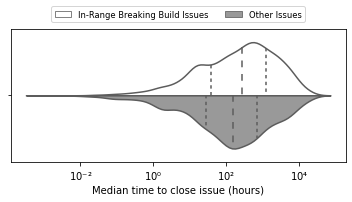

	Mann-Whitney: statistic=12397413.5 pvalue=5.64576217794053e-22
	Cliff'a Delta: delta=0.10756817343107357 size=negligible
    


In [46]:
# Calculate mean and median intra-project time_to_close for Non-GK issues
non_gk_issues__closed = non_gk_issues[non_gk_issues['state'] == 'closed'].copy()
non_gk_issues__closed['time_to_close'] = (
    (non_gk_issues__closed['closed_at'] - non_gk_issues__closed['created_at'])
        .dt
        .total_seconds()  # Have to convert to seconds to calculate mean and median
)
project__non_gk_issue__time_to_close = (
    non_gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
        .dropna()
)
project__non_gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['mean'],
    unit='s'
)
project__non_gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['median'],
    unit='s'
)
project__non_gk_issue__time_to_close['median_hours'] = (
    project__non_gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['median_hours']
)

# Calculate mean and median intra-project time_to_close for GK issues
gk_issues__closed = gk_issues[gk_issues['state'] == 'closed'].copy()
gk_issues__closed['time_to_close'] = (
    gk_issues__closed['closed_at'] - gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__gk_issue__time_to_close = (
    gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
        .dropna()
)
project__gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__gk_issue__time_to_close['mean'],
    unit='s'
)
project__gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__gk_issue__time_to_close['median'],
    unit='s'
)
project__gk_issue__time_to_close['median_hours'] = (
    project__gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__gk_issue__time_to_close['median_hours']
)

# Merge the two
project__all_issues__time_to_close = project__non_gk_issue__time_to_close.merge(
    project__gk_issue__time_to_close,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)

# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_close,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_close_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
sns.violinplot(
    data=melted,
    x='median_time_to_close_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to close issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2,
    shadow=False,
)
L.get_texts()[0].set_text('In-Range Breaking Build Issues')
L.get_texts()[1].set_text('Other Issues')
print('--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--')
tfns(
    project__all_issues__time_to_close,
    ['median_non_gk', 'median_gk'],
    title='Median time to close issue'
)
save_fig('intra_project_median_time_to_close')
plt.show()

mannwhitneyu_cliffsdelta(
    project__all_issues__time_to_close['median_hours_log_gk'],
    project__all_issues__time_to_close['median_hours_log_non_gk']
)

<h3>What dependency types are GKIRs opened for?</h3>

In [35]:
gk_issues['dependency_type'].value_counts() / gk_issues['dependency_type'].count()

devDependency         0.699488
dependency            0.298634
optionalDependency    0.001166
peerDependency        0.000712
Name: dependency_type, dtype: float64

<ipython-input-54-8c6bd8f8e772>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=12)


	Mann-Whitney: statistic=280485112.5 pvalue=1.5314886489480827e-12
	Cliff'a Delta: delta=0.03839378533679006 size=negligible
    


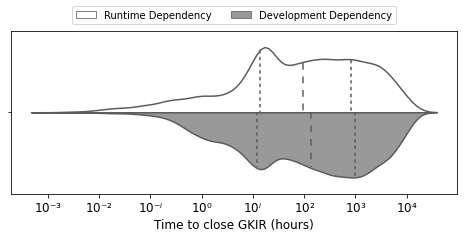

In [54]:
gk_issues_simplified = (
    gk_issues[
        gk_issues['state'] == 'closed'
    ][
        ['created_at', 'closed_at', 'dependency_type']
    ].dropna()
    .copy()
)
gk_issues_simplified['time_to_close'] = (
    gk_issues_simplified['closed_at'] - gk_issues_simplified['created_at']
)
gk_issues_simplified['time_to_close_hours'] = (
    gk_issues_simplified['time_to_close'] / np.timedelta64(1, 'h')
)
gk_issues_simplified['time_to_close_hours_log'] = (
    np.log10(gk_issues_simplified['time_to_close_hours'])
)
types_to_analyze = ['devDependency', 'dependency']
gk_issues_simplified = gk_issues_simplified[gk_issues_simplified['dependency_type'].isin(types_to_analyze)]
gk_issues_simplified.dependency_type = (
    gk_issues_simplified
        .dependency_type
        .cat
        .remove_categories(['optionalDependency', 'peerDependency'])
)
gk_issues_simplified['placeholder'] = ''

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=gk_issues_simplified,
    x='time_to_close_hours_log',
    y='placeholder',
    hue='dependency_type',
#     order=['large', 'medium', 'small'],
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    scale='width',
    ax=ax,
)

ax.set_ylabel('', fontsize=12)

ax.set_xlabel('Time to close GKIR (hours)', fontsize=12)
ax.set_xticklabels(ax.get_xticks(), fontsize=12)
ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fancybox=True,
    bbox_to_anchor=(0.5,1.18),
    ncol=2,
    shadow=False,
)
L.get_texts()[0].set_text('Runtime Dependency')
L.get_texts()[1].set_text('Development Dependency')


mannwhitneyu_cliffsdelta(
    gk_issues_simplified[gk_issues_simplified['dependency_type'] == 'devDependency']['time_to_close_hours_log'],
    gk_issues_simplified[gk_issues_simplified['dependency_type'] == 'dependency']['time_to_close_hours_log']
)

plt.show()
